DATA CLEANING


🔍 Null values in each column:

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


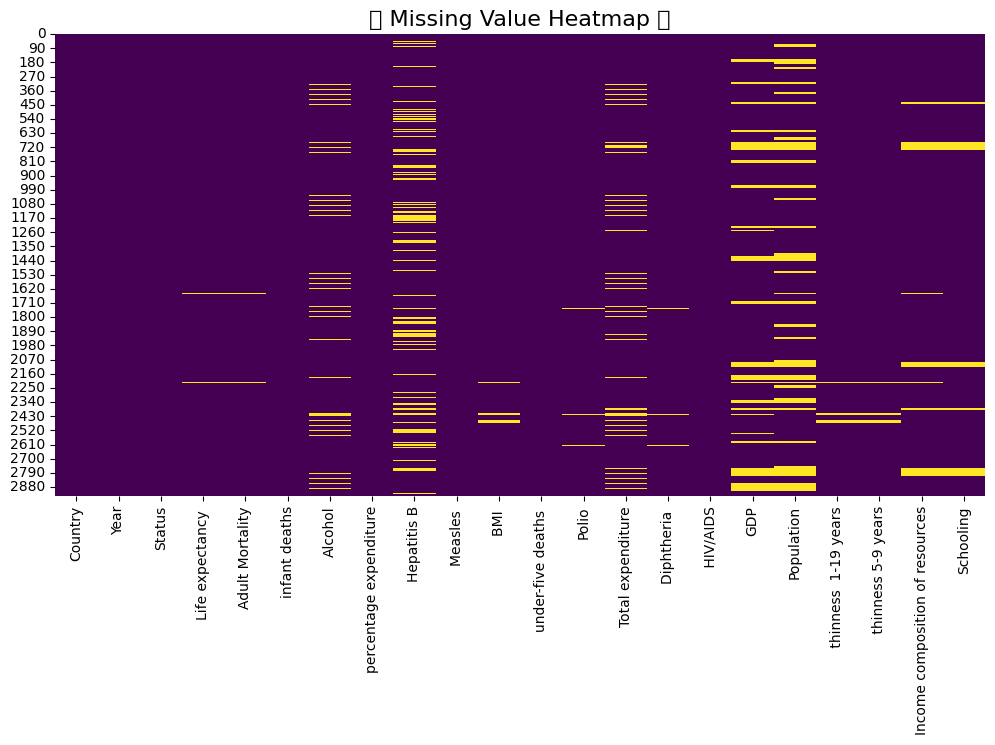


✅ Null values after cleaning:

0


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Life Expectancy Data.csv")  # Use your exact filename

# 1. Check for Null Values
print("\n🔍 Null values in each column:\n")
print(df.isnull().sum())

# 2. Visualize Missing Values with a Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("✨ Missing Value Heatmap ✨", fontsize=16)
plt.show()

# 3. Fill missing numeric values with median or mean
numeric_cols = df.select_dtypes(include='number').columns

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# 4. Fill missing categorical values with mode or 'Unknown'
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val if mode_val else 'Unknown')

# Confirm all nulls are gone
print("\n✅ Null values after cleaning:\n")
print(df.isnull().sum().sum())  # Should print 0 if all are filled

FIX DATA TYPES

In [2]:
# 🌟 Convert 'Year' to datetime or integer
try:
    df['Year'] = pd.to_datetime(df['Year'], format='%Y')
except:
    df['Year'] = df['Year'].astype(int)

# 🌟 Convert columns like GDP, Population, BMI to numeric
# Fix the column name with leading space
cols_to_convert = ['GDP', 'Population', 'BMI ']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 🌟 (Optional) View updated data types
print(df[cols_to_convert + ['Year']].dtypes)

# 🌟 (Optional) Check for NaNs introduced during conversion
print("\n🧪 Nulls After Conversion:\n")
print(df[cols_to_convert].isnull().sum())

GDP                  float64
Population           float64
BMI                  float64
Year          datetime64[ns]
dtype: object

🧪 Nulls After Conversion:

GDP           0
Population    0
BMI           0
dtype: int64


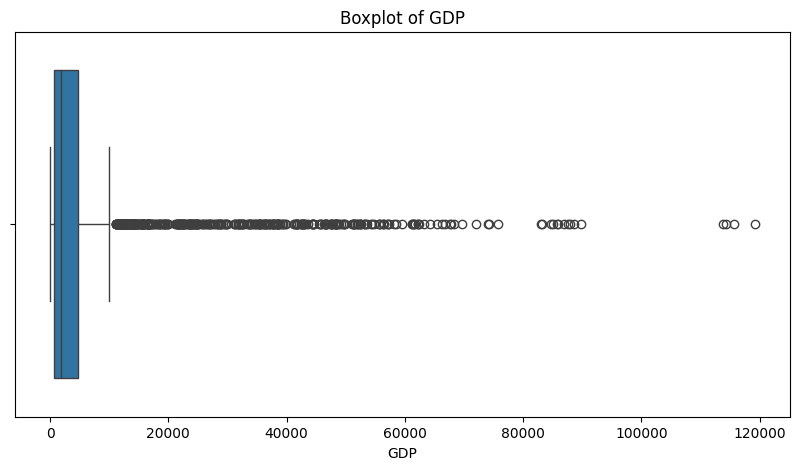

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 💸 Boxplot for GDP (or any other column you wanna check)
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['GDP'])
plt.title('Boxplot of GDP')
plt.xlabel('GDP')
plt.show()


In [4]:
from scipy.stats import zscore

# 🎯 Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# 🧮 Compute Z-scores
z_scores = df[numeric_cols].apply(zscore)

# ✅ Keep rows where all z-scores are within 3 standard deviations
df_clean = df[(z_scores < 3).all(axis=1)]

print(f"Before: {df.shape[0]} rows")
print(f"After: {df_clean.shape[0]} rows")


Before: 2938 rows
After: 2597 rows


In [5]:
# Save your cleaned DataFrame to a CSV file
df_clean.to_csv('cleaned_dataset.csv', index=False)

print("✅ Cleaned dataset saved as 'cleaned_dataset.csv'")


✅ Cleaned dataset saved as 'cleaned_dataset.csv'


In [6]:
!pip install Dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.0 MB/s eta 0:00:00


DASHBOARD

In [9]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd

# Load and clean data
df = pd.read_csv("Life Expectancy Data.csv")
df.columns = df.columns.str.strip()

if 'Region' not in df.columns:
    df['Region'] = 'Unknown'

# For bar and scatter charts
top_10_countries = (
    df.groupby("Country")["Life expectancy"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index
)
countries = sorted(df['Country'].dropna().unique())
statuses = df['Status'].dropna().unique()

# App setup
app = dash.Dash(__name__)
app.title = "Global Health Dashboard"

# Layout
app.layout = html.Div([
    html.H1("🌍 Global Life Expectancy Dashboard", style={"textAlign": "center", "color": "white"}),
    html.Div(style={"width": "98%", "margin": "auto"}, children=[
        dcc.Tabs([

            dcc.Tab(label='🏁 Bar Chart Race – Top 10 Countries', children=[
                dcc.Graph(id='bar-chart-race')
            ]),

            dcc.Tab(label='📈 Line Chart – Developed vs Developing', children=[
                html.Div([
                    html.Label("Select View", style={'color': 'white'}),
                    dcc.Dropdown(
                        id='line-view-dropdown',
                        options=[
                            {'label': 'Developed vs Developing', 'value': 'status'},
                            {'label': 'All Countries', 'value': 'country'}
                        ],
                        value='status',
                        style={'width': '50%', 'marginBottom': '10px'}
                    ),
                    dcc.Graph(id='line-chart')
                ], style={'padding': '10px'})
            ]),

            dcc.Tab(label='🍩 Donut – Top 10 Countries by Life Expectancy', children=[
                dcc.Graph(id='donut-chart')
            ]),

            dcc.Tab(label='🗺️ Bubble Map – Life Expectancy & GDP (2015)', children=[
                dcc.Graph(id='bubble-map')
            ]),

            dcc.Tab(label='⚕️ Scatter – Mortality vs Longevity', children=[
                html.Div([
                    html.Label("Filter by Country or Status", style={'color': 'white'}),
                    dcc.Dropdown(
                        id='scatter-dropdown',
                        options=[{'label': s, 'value': s} for s in countries] +
                                [{'label': s, 'value': s} for s in statuses],
                        value=None,
                        placeholder="Select Country or Status (optional)"
                    )
                ], style={'padding': '10px'}),
                dcc.Graph(id='scatter-plot')
            ]),

            dcc.Tab(label='📊 Column – Infant Deaths Over Time', children=[
                dcc.Graph(id='column-chart')
            ])
        ])
    ])
], style={'backgroundColor': '#111', 'color': 'white'})

# 1. Bar Chart Race
@app.callback(Output('bar-chart-race', 'figure'), Input('bar-chart-race', 'id'))
def update_bar_chart(_):
    df_top10 = df[df['Country'].isin(top_10_countries)].dropna(subset=['Life expectancy'])
    fig = px.bar(
        df_top10, x='Life expectancy', y='Country', color='Country',
        animation_frame='Year', orientation='h', range_x=[60, 90],
        title='🏁 Top 10 Countries by Life Expectancy (Animated)',
        color_discrete_sequence=px.colors.qualitative.Dark24,
        template='plotly_dark'
    )
    fig.update_layout(height=600)
    fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1600
    fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 900
    return fig

# 2. Line Chart with View Toggle
@app.callback(Output('line-chart', 'figure'), Input('line-view-dropdown', 'value'))
def update_line_chart(view_mode):
    df_line = df.dropna(subset=['Life expectancy', 'Status', 'Year', 'Country'])

    if view_mode == 'status':
        grouped = df_line.groupby(['Year', 'Status'])['Life expectancy'].mean().reset_index()
        fig = px.line(grouped, x='Year', y='Life expectancy', color='Status',
                      title='📈 Life Expectancy – Developed vs Developing',
                      markers=True, template='plotly_dark',
                      color_discrete_sequence=['#004d4d', '#660000'])
    else:
        grouped = df_line.groupby(['Year', 'Country'])['Life expectancy'].mean().reset_index()
        fig = px.line(grouped, x='Year', y='Life expectancy', color='Country',
                      title='🌍 Life Expectancy – All Countries',
                      markers=False, template='plotly_dark')

    fig.update_layout(height=500)
    return fig

# 3. Donut Chart (replaces Treemap)
@app.callback(Output('donut-chart', 'figure'), Input('donut-chart', 'id'))
def update_donut_chart(_):
    df_2015 = df[df['Year'] == 2015].dropna(subset=['Life expectancy', 'Country'])
    top_10 = df_2015.groupby('Country')['Life expectancy'].mean().nlargest(10).reset_index()

    fig = px.pie(top_10, names='Country', values='Life expectancy',
                 title='🍩 Top 10 Countries by Life Expectancy (2015)',
                 hole=0.4, template='plotly_dark',
                 color_discrete_sequence=px.colors.sequential.Aggrnyl)

    fig.update_traces(textinfo='percent+label')
    fig.update_layout(height=600)
    return fig

# 4. Bubble Map
@app.callback(Output('bubble-map', 'figure'), Input('bubble-map', 'id'))
def update_map_plot(_):
    df_map = df[df['Year'] == 2015].dropna(subset=['Life expectancy', 'GDP', 'Population'])
    fig = px.scatter_geo(df_map,
                         locations="Country",
                         locationmode="country names",
                         color="Life expectancy",
                         size="GDP",
                         hover_name="Country",
                         size_max=50,
                         title="🌐 2015 Bubble Map: Life Expectancy & GDP",
                         template='plotly_dark',
                         color_continuous_scale=px.colors.sequential.Viridis,
                         projection="natural earth")
    fig.update_layout(height=600)
    return fig

# 5. Scatter Plot
@app.callback(Output('scatter-plot', 'figure'), Input('scatter-dropdown', 'value'))
def update_scatter_plot(filter_value):
    df_scatter = df.dropna(subset=['Adult Mortality', 'Life expectancy', 'Status', 'Income composition of resources'])
    df_scatter = df_scatter[df_scatter['Adult Mortality'] < 400]
    if filter_value in statuses:
        df_scatter = df_scatter[df_scatter['Status'] == filter_value]
    elif filter_value in countries:
        df_scatter = df_scatter[df_scatter['Country'] == filter_value]

    fig = px.scatter(df_scatter, x='Adult Mortality', y='Life expectancy',
                     color='Status', size='Income composition of resources', hover_name='Country',
                     title='⚕️ Mortality vs Longevity (Log Scale)',
                     log_x=True, template='plotly_dark',
                     hover_data=['GDP', 'Schooling', 'Country'])
    fig.update_layout(height=500)
    return fig

# 6. Column Chart
@app.callback(Output('column-chart', 'figure'), Input('column-chart', 'id'))
def update_column_chart(_):
    df_anim = df.dropna(subset=['infant deaths', 'Country'])
    df_anim = df_anim[df_anim['infant deaths'] > 0]
    df_anim = df_anim.groupby(['Year', 'Country'])['infant deaths'].sum().reset_index()
    top_countries = df_anim.groupby('Country')['infant deaths'].sum().nlargest(10).index
    df_anim = df_anim[df_anim['Country'].isin(top_countries)]

    fig = px.bar(df_anim, x='infant deaths', y='Country', color='Country',
                 animation_frame='Year', orientation='h',
                 title='📊 Infant Deaths – Top 10 Countries Over Time',
                 color_discrete_sequence=px.colors.sequential.Redor_r,
                 template='plotly_dark')
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1200
    fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 500
    fig.update_layout(height=600)
    return fig

# Run server
if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>